# In this project I am going to use combination of different classification models to predict if a transaction is a Fraud.

This is a competition on Kaggle.com https://www.kaggle.com/c/ieee-fraud-detection/overview
We are given two data sets called transaction and identity data sets that contain explicit and encripted information about transactions which are either legitimate or Fraud. Our task is to figure out the fraudulent transactions on the test data set.

Let's start by importing pandas and numpy (also preprocessing from scikit-learn library to process our text data)

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

train = pd.read_csv('Desktop/fraud detection/train_transaction.csv')
label = train['isFraud']


Our train_transaction file contains a lot of columns, namely 394 and one of the columns is isFraud this is our target.

In [2]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The total amout of fradulent transactions is less then 4 percent. Before training our data we need to oversample the fraudulent transactions in order to get rid of the class imbalance.

In [39]:
train.isFraud.sum()/len(train.isFraud)

0.03499000914417313

Data also consists of many text columns like ProductCD, and NaN values for many columns which should be dealt with. I had tried to remove columns containing a lot of NaNs but this is not a good idea without a legitimizing statistical test as these columns can still contain important information in determining if a casa is a fraud.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


Our second file train_identity is consists of less data every transaction id in this file also exists in the first file. This data is basically 'extra' data on top of the first one that the company could capture for some transactions.

In [4]:
train_identity = pd.read_csv('Desktop/fraud detection/train_identity.csv')


The file has a lot of NaN values but fewer columns (41) we will need to merge these two data.

In [5]:
train_identity.head()
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

I performed an outer merge where every data point in the first file is kept intact and the second file is merged on the transaction id creating many NaN values for transactions that do not have the columns in the second file.

In [6]:

train_both = pd.merge(train, train_identity, on = 'TransactionID', how = 'outer')

train = train_both

One way to investigate the data further is to look at the scatter plot of transactions vs time, this shows us that the frauds are homogenous in time (at least for this resolution)

In [7]:
normal = train[train.isFraud == 0]
fraud = train[train.isFraud == 1]


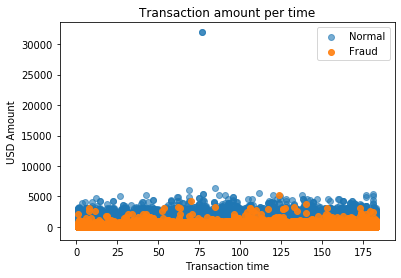

In [22]:
import matplotlib.pyplot as plt


plt.scatter((normal.TransactionDT/(60*60*24)), normal.TransactionAmt, alpha=0.6, label='Normal')
plt.scatter((fraud.TransactionDT/(60*60*24)), fraud.TransactionAmt, alpha=0.9, label='Fraud')
plt.title("Transaction amount per time")
plt.xlabel("Transaction time")
plt.ylabel('USD Amount')
plt.legend(loc='upper right')
plt.show()

One way to get rid of the NaN values in the numeric columns is to fill them with 0, averages would be another option that comes to mind first. Which one is more meaningful depends on the data columns and how they relate to isFraud columns (which is dropped from the train data in the second line)

In [9]:
train_numeric = train._get_numeric_data().fillna(0)
train_numeric = train_numeric.drop(columns=['isFraud'])


The text data (encoded object) had also a lot of NaN values which are replaced with an empty string here.

In [10]:
train_text = train.select_dtypes(include='object').fillna('').astype('str')

Before we can train our data at all, we need to preprocess our text columns, one way to do this is to use a LabelEncoder to easily assign numerical values to each word. In this data set, as most data are single words, we do not need to do nlp (natural language processing) for the most columns except maybe for the Device info, Device Type and email columns which are composed of multiple words or long strings seperated by punctuation.

In [11]:
le = preprocessing.LabelEncoder()
for id in train_text.columns:
    train_text[id] = le.fit_transform(train_text[id])
    print(id)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


Finally I merge numeric and text columns by concatenating them over their rows.

In [12]:
train_all = pd.concat([train_numeric, train_text], axis=1)

The dataframe now consists of only numeric values and no NaNs but checking the description of the data we see that columns have many order of magnitude differences between them. In order for the models to work best on the data we will also need to scale them.

In [13]:
train_all.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,13926,0.0,150.0,142.0,315.0,87.0,19.0,...,0,0,0,0,0,0,0,0,0,0
1,2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2987002,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,0,0,0,0,0,0,0,0,0,0
3,2987003,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2987004,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,0.0,...,8,124,165,4,2,1,2,2,2,955


Scaling is done using scikit-learn's scale which bring the std of every column to 1.

In [14]:
from sklearn.preprocessing import scale

In [15]:
for i in train_all.columns:
    train_all[i] = scale(train_all[i])
train_all.tail()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,1.732024,1.827666,-0.359702,-0.683253,-2.194286,-0.202222,0.633905,0.102746,0.359582,0.000769,...,-0.358081,-0.514983,-0.332267,-0.38657,-0.525678,-0.545035,-0.541363,-0.522109,-0.519255,-0.473565
590536,1.732030,1.827666,-0.399424,0.111252,-0.811608,-0.202222,0.588880,-0.410438,0.359582,-0.196550,...,-0.358081,-0.514983,-0.332267,-0.38657,-0.525678,-0.545035,-0.541363,-0.522109,-0.519255,-0.473565
590537,1.732036,1.827673,-0.435174,0.436277,1.462128,-0.202222,0.588880,-0.206674,0.359582,-0.196550,...,-0.358081,-0.514983,-0.332267,-0.38657,-0.525678,-0.545035,-0.541363,-0.522109,-0.519255,-0.473565
590538,1.732042,1.827675,-0.075376,-0.422906,0.761572,-0.202222,0.588880,0.970632,0.359582,-0.184217,...,-0.358081,-0.514983,-0.332267,-0.38657,-0.525678,-0.545035,-0.541363,-0.522109,-0.519255,-0.473565
590539,1.732048,1.827684,0.605960,1.054293,-1.149596,-0.202222,-2.157605,0.306511,0.359582,-0.196550,...,-0.358081,-0.514983,-0.332267,-0.38657,-0.525678,-0.545035,-0.541363,-0.522109,-0.519255,-0.473565


I also dropped the TransactionID column as we no longer need it to train the data.

In [16]:
train_all = train_all.drop(columns= ['TransactionID'])


Another analysis that could be useful is the principle compoenent analysis (PCA), it reduces the number of columns by rotating the data samples and shifting them to have 0 mean.

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 150)
principal_comps = pca.fit_transform(train_all)
train_all = pd.DataFrame(principal_comps)


Data imbalance issue is addressed using RandomOverSampler instead of SMOTE, SMOTE interpolates the data to create more data points, I didn't prefer this method because the disadvantage is that the new points can be non-fraudulent cases, instead RandomOverSampler increases the data number by copying them, its disadventage is that it trains the model over and over again using the same data which is not really ideal. I also split the data before applying RandomOverSampler, albeit I only use 2 percent of the data to test my overall model.

In [18]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#os = SMOTE(random_state=0)
os = RandomOverSampler()

X_train, X_test, y_train, y_test = train_test_split(train_all, label, test_size=0.02, random_state=0)

columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['isFraud'])



Using TensorFlow backend.


I have tried many models and each one has different results, some of them need to be optimized using different arguments but in the end I decided to combine 3 of them for my overall model.

In [19]:
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


RandomForestClassifier gave the best results by itself so I increased its weight in my VotingClassifier. LogisticRegression needs the solver argument 'sag' to make calculations faster as it's very memory extensive, for the DecisionTreeClassifier 'gini' criterion was used for the branching with a maximum depth of 7.

In [20]:
clf2 = LogisticRegression(solver = 'sag',random_state = 1)
clf3 = RandomForestClassifier(random_state = 1)
clf4 = DecisionTreeClassifier(criterion='gini' ,random_state = 1,max_depth = 7)

ensemble_model = VotingClassifier(estimators = [('lr', clf2), ('rf', clf3), ('dt', clf4)], voting = 'soft',weights = [1,2,1])
ensemble_model.fit(os_data_X,os_data_y)

y_pred = ensemble_model.predict(X_test)




/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/enescaglar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to

I finally print useful metrics to see how well the system performs. Roc score of 1 is expected for a good model. Even without too much data manipulation it was possible to catch many fraud cases with an roc score of 0.74.

In [21]:
print('cnf_matrix:' ,metrics.confusion_matrix(y_test, y_pred))
print('Accuracy:',metrics.accuracy_score(y_test, y_pred))
print('Precision:',metrics.precision_score(y_test, y_pred))
print('Recall:',metrics.recall_score(y_test, y_pred))
print('roc_score:',roc_auc_score(y_test, y_pred))

cnf_matrix: [[11298   124]
 [  195   194]]
Accuracy: 0.9729912793158919
Precision: 0.610062893081761
Recall: 0.4987146529562982
roc_score: 0.7439292053084766


Before I make predictions based on my ensemble model, I make sure that I have the correct submission format and further process the test data the same way I processed the training data (consists of merging the data frames, replacing NaN values, label encoding etc.).

In [23]:
submission = pd.read_csv('Desktop/fraud detection/sample_submission.csv')

submission.head()



,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [24]:
test = pd.read_csv('Desktop/fraud detection/test_transaction.csv')
test_identity = pd.read_csv('Desktop/fraud detection/test_identity.csv')

test = pd.merge(test, test_identity, on = 'TransactionID', how = 'outer')

In [25]:
test_numeric = test._get_numeric_data().fillna(0)
test_text = test.select_dtypes(include='object').fillna('').astype('str')

test.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,498037.000000,503689.000000,502144.000000,441082.000000,441082.000000,215474.000000,...,135966.000000,50875.000000,135906.000000,135633.000000,5059.000000,5062.000000,4740.000000,5039.000000,5047.000000,70671.000000
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,363.735379,153.543409,200.162975,291.846514,86.723412,87.065270,...,191.070341,14.795735,350.122982,408.886230,507.727021,15.336823,13.166667,332.043064,152.752923,26.217939
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,158.688653,12.443013,40.562461,102.062730,2.987328,314.131694,...,30.749535,2.318496,139.140824,158.971756,227.371061,5.618032,3.222440,86.356683,31.916995,3.601046
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,...,100.000000,11.000000,100.000000,100.000000,100.000000,11.000000,10.000000,100.000000,100.000000,8.000000
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,207.000000,150.000000,166.000000,204.000000,87.000000,3.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,137.000000,24.000000
50%,3.916894e+06,2.720466e+07,67.950000,9803.000000,369.000000,150.000000,226.000000,299.000000,87.000000,8.000000,...,166.000000,15.000000,321.000000,484.000000,576.000000,14.000000,11.000000,321.000000,147.000000,24.000000
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.000000,150.000000,226.000000,330.000000,87.000000,20.000000,...,225.000000,15.000000,427.000000,549.000000,711.000000,14.000000,15.000000,355.000000,182.000000,32.000000
max,4.170239e+06,3.421434e+07,10270.000000,18397.000000,600.000000,232.000000,237.000000,540.000000,102.000000,8081.000000,...,228.000000,29.000000,670.000000,660.000000,854.000000,44.000000,26.000000,549.000000,216.000000,48.000000


In [26]:
le = preprocessing.LabelEncoder()
for id in test_text.columns:
    test_text[id] = le.fit_transform(test_text[id])

In [27]:
test_all = pd.concat([test_numeric, test_text], axis=1)
test_all.describe()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.066910e+05,5.066910e+05,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,...,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000
mean,3.916894e+06,2.692994e+07,134.725568,9957.222175,357.522981,152.633708,198.366730,254.056701,75.494011,37.025134,...,7.127352,19.063577,22.185896,0.284886,0.411744,0.277619,0.476965,0.353067,0.393650,385.689738
std,1.462692e+05,4.756507e+06,245.779822,4884.960969,164.234805,17.110306,44.574255,136.633636,29.249321,209.323845,...,19.375609,34.520743,62.925779,0.699007,0.724588,0.463802,0.814081,0.627593,0.696778,760.650634
min,3.663549e+06,1.840322e+07,0.018000,1001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.790222e+06,2.277154e+07,40.000000,6019.000000,203.000000,150.000000,166.000000,184.000000,87.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.916894e+06,2.720466e+07,67.950000,9803.000000,361.000000,150.000000,226.000000,269.000000,87.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.043566e+06,3.134856e+07,125.000000,14276.000000,512.000000,150.000000,226.000000,327.000000,87.000000,6.000000,...,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,4.170239e+06,3.421434e+07,10270.000000,18397.000000,600.000000,232.000000,237.000000,540.000000,102.000000,8081.000000,...,86.000000,135.000000,390.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2226.000000


In [28]:
for i in test_all.columns:
    test_all[i] = scale(test_all[i])
test_all.tail()


,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
506686,1.732020,1.531449,-0.162937,0.793206,0.106415,1.891627,0.575070,0.219150,-0.529723,-0.17688,...,-0.367852,-0.552236,-0.352573,-0.407558,-0.568247,-0.598573,-0.585894,-0.562574,-0.564958,-0.507053
506687,1.732027,1.531451,-0.498628,-1.392688,0.307347,1.891627,0.575070,-1.859403,-2.581054,-0.17688,...,-0.367852,-0.378427,-0.352573,-0.407558,0.811850,1.557522,1.870865,1.030816,2.305398,-0.365069
506688,1.732034,1.531459,-0.348790,1.372331,0.806633,-0.153925,0.619939,0.533861,0.393377,-0.17688,...,-0.367852,-0.552236,-0.352573,-0.407558,-0.568247,-0.598573,-0.585894,-0.562574,-0.564958,-0.507053
506689,1.732041,1.531462,0.273719,1.364143,0.964943,-0.153925,0.575070,-0.563966,0.393377,-0.17688,...,-0.367852,-0.552236,-0.352573,-0.407558,-0.568247,-0.598573,-0.585894,-0.562574,-0.564958,-0.507053
506690,1.732047,1.531463,-0.449100,-0.868835,-1.153977,-0.504592,-1.152387,-1.859403,-2.581054,-0.17688,...,-0.367852,3.329492,-0.352573,-0.407558,0.811850,1.557522,1.870865,1.030816,2.305398,1.082377


In [29]:
test_all = test_all.drop(columns= ['TransactionID'])
test_all.describe()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,...,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05,5.066910e+05
mean,-7.398097e-15,-6.176123e-15,1.441786e-15,2.557089e-14,-1.752649e-14,6.833042e-14,-4.151602e-15,-2.015420e-13,-6.441932e-14,-2.853736e-13,...,-7.965539e-13,-1.417606e-12,-1.081762e-12,1.974560e-13,6.253084e-14,5.767867e-13,-7.293617e-13,7.761746e-13,1.011003e-12,5.532640e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.792644e+00,-5.480828e-01,-1.833429e+00,-2.176904e+00,-8.920580e+00,-4.450258e+00,-1.859403e+00,-2.581054e+00,-1.768798e-01,-1.057321e-01,...,-3.678521e-01,-5.522360e-01,-3.525728e-01,-4.075582e-01,-5.682466e-01,-5.985728e-01,-5.858944e-01,-5.625739e-01,-5.649582e-01,-5.070529e-01
25%,-8.742552e-01,-3.854086e-01,-8.061940e-01,-9.408672e-01,-1.539254e-01,-7.261313e-01,-5.127344e-01,3.933767e-01,-1.768798e-01,-1.057321e-01,...,-3.678521e-01,-5.522360e-01,-3.525728e-01,-4.075582e-01,-5.682466e-01,-5.985728e-01,-5.858944e-01,-5.625739e-01,-5.649582e-01,-5.070529e-01
50%,5.775689e-02,-2.716888e-01,-3.157084e-02,2.117104e-02,-1.539254e-01,6.199385e-01,1.093678e-01,3.933767e-01,-1.768798e-01,-1.057321e-01,...,-3.678521e-01,-5.522360e-01,-3.525728e-01,-4.075582e-01,-5.682466e-01,-5.985728e-01,-5.858944e-01,-5.625739e-01,-5.649582e-01,-5.070529e-01
75%,9.289649e-01,-3.957029e-02,8.840976e-01,9.405873e-01,-1.539254e-01,6.199385e-01,5.338610e-01,3.933767e-01,-1.482161e-01,-1.057321e-01,...,-3.678521e-01,7.513294e-01,-3.525728e-01,-4.075582e-01,8.118501e-01,1.557522e+00,6.424852e-01,1.030816e+00,8.702201e-01,-5.070529e-01
max,1.531463e+00,4.123725e+01,1.727708e+00,1.476406e+00,4.638513e+00,8.667180e-01,2.092776e+00,9.062096e-01,3.842841e+01,5.700943e+01,...,4.070722e+00,3.358460e+00,5.845211e+00,2.453647e+00,2.191947e+00,3.713618e+00,1.870865e+00,2.624206e+00,2.305398e+00,2.419392e+00


In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 150)
principal_comps_test = pca.fit_transform(test_all)
transformed_test = pd.DataFrame(principal_comps_test)


Predictions are obtained using a single line of code and written on a csv file using the correct format.

In [32]:
test_pred = ensemble_model.predict(transformed_test)

In [33]:
file = pd.read_csv('Desktop/fraud detection/test_transaction.csv')

resultdf = pd.DataFrame()

In [34]:
resultdf['TransactionID'] = file.TransactionID

In [35]:
resultdf['isFraud'] = test_pred

In [37]:
resultdf.head()

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0


In [38]:
resultdf.to_csv('Desktop/fraud detection/my_submission.csv',index=False)